<a href="https://colab.research.google.com/drive/1HWqta3KrI_x_Gr5ugy6B7cfMTrvDPRQC?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)


# Behavior Cloning

Using expert demonstrations (observations-actions pairs), as a supervised learning problem. The policy network is trained to reproduce the expert behavior. Expert trajectories can be:
- Human demonstrations
- Trajectories from another controller (e.g. a PID controller)
- Trajectories from a trained RL agent

--- 

Steps:  
- Generate and save trajectories (ex: using a trained DQN agent)
- Load expert trajectories
- Initialize RL agent 
   - Evaluate the untainted agent 
- Pretrain the RL model (ex: PPO2) in a supervised way
   - Evaluate the pre-trained PPO2 model  
- Train the RL model for self improvement 
   - Evaluate the final RL model 


## Install

In [0]:
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
# !pip install pyglet==1.3.2
!pip install pyglet
!pip install stable-baselines
!pip install stable-baselines --upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Requirement already up-to-date: stable-baselines in /usr/local/lib/python3.6/dist-packages (2.9.0)


## Generate and save trajectories

In [0]:
# Train a DQN agent and generate and save trajectories
from stable_baselines import DQN
from stable_baselines.gail import generate_expert_traj

model = DQN('MlpPolicy', 'CartPole-v0', verbose=1)
generate_expert_traj(model, 'expert_cartpole', n_timesteps=int(1e4), n_episodes=10)

results_mean_list = [] 
results_std_list = [] 

Creating environment from the given name, wrapped in a DummyVecEnv.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 100      |
| mean 100 episode reward | 19.4     |
| steps                   | 1917     |
--------------------------------------
actions (1136, 1)
obs (1136, 4)
rewards (1136,)
episode_returns (10,)
episode_starts (1136,)


## Load expert trajectories

In [0]:
from stable_baselines import PPO2
from stable_baselines.gail import ExpertDataset
# traj_limitation=-1  -> whole dataset
dataset = ExpertDataset(expert_path='expert_cartpole.npz',
                        traj_limitation=1, batch_size=128)

actions (1136, 1)
obs (1136, 4)
rewards (1136,)
episode_returns (10,)
episode_starts (1136,)
Total trajectories: 1
Total transitions: 212
Average returns: 113.6
Std for returns: 7.977468270071653


## Evalaute the random model

In [0]:
model = PPO2('MlpPolicy', 'CartPole-v0', verbose=1)

Creating environment from the given name, wrapped in a DummyVecEnv.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
import numpy as np
# Test The random model

env = model.get_env()
obs = env.reset()
r_list = []

for i in range(10):
  print("\riteration: {}".format(i), end="")
  reward_sum = 0.0
  for _ in range(1000):
          action, _ = model.predict(obs)
          obs, reward, done, _ = env.step(action)
          reward_sum += reward
          if done:
                  r_list.append(reward_sum)
                  reward_sum = 0.0
                  obs = env.reset()

print('\nmean, std')
print(np.mean(r_list), np.std(r_list))
results_mean_list.append(np.mean(r_list))
results_std_list.append(np.std(r_list)) 
env.close()

iteration: 9
mean, std
22.29054 11.437996


## Pretrain the PPO2 model

In [0]:
model.pretrain(dataset, n_epochs=2000)

Pretraining with Behavior Cloning...
==== Training progress 10.00% ====
Epoch 200
Training loss: 0.628646, Validation loss: 0.604446

==== Training progress 20.00% ====
Epoch 400
Training loss: 0.554622, Validation loss: 0.533716

==== Training progress 30.00% ====
Epoch 600
Training loss: 0.505957, Validation loss: 0.511930

==== Training progress 40.00% ====
Epoch 800
Training loss: 0.501154, Validation loss: 0.492628

==== Training progress 50.00% ====
Epoch 1000
Training loss: 0.524606, Validation loss: 0.476109

==== Training progress 60.00% ====
Epoch 1200
Training loss: 0.549335, Validation loss: 0.439680

==== Training progress 70.00% ====
Epoch 1400
Training loss: 0.410501, Validation loss: 0.419609

==== Training progress 80.00% ====
Epoch 1600
Training loss: 0.371578, Validation loss: 0.403743

==== Training progress 90.00% ====
Epoch 1800
Training loss: 0.389727, Validation loss: 0.400651

==== Training progress 100.00% ====
Epoch 2000
Training loss: 0.338221, Validation lo

In [0]:
# test the pretrained PPO model
env = model.get_env()
obs = env.reset()
r_list = []

for i in range(10):
  print("\riteration: {}".format(i), end="")
  reward_sum = 0.0
  for _ in range(1000):
          action, _ = model.predict(obs)
          obs, reward, done, _ = env.step(action)
          reward_sum += reward
          if done:
                  r_list.append(reward_sum)
                  reward_sum = 0.0
                  obs = env.reset()

print('\nmean, std')
print(np.mean(r_list), np.std(r_list))
results_mean_list.append(np.mean(r_list))
results_std_list.append(np.std(r_list)) 
env.close()

iteration: 9
mean, std
67.86331 42.964966


## Train the RL agent

In [0]:
model.learn(int(1e5))

Streaming output truncated to the last 5000 lines.
| policy_entropy     | 0.4632867    |
| policy_loss        | -0.011270072 |
| serial_timesteps   | 50816        |
| time_elapsed       | 102          |
| total_timesteps    | 50816        |
| value_loss         | 0.36167085   |
-------------------------------------
--------------------------------------
| approxkl           | 0.0010593967  |
| clipfrac           | 0.00390625    |
| explained_variance | 0.994         |
| fps                | 491           |
| n_updates          | 398           |
| policy_entropy     | 0.4422183     |
| policy_loss        | -0.0013926309 |
| serial_timesteps   | 50944         |
| time_elapsed       | 102           |
| total_timesteps    | 50944         |
| value_loss         | 1.8285588     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0012952393  |
| clipfrac           | 0.015625      |
| explained_variance | 0.993         |
| fps               

## Final Evalaution

In [0]:
env = model.get_env()
obs = env.reset()
r_list = []

for i in range(10):
  print("\riteration: {}".format(i), end="")
  reward_sum = 0.0
  for _ in range(1000):
          action, _ = model.predict(obs)
          obs, reward, done, _ = env.step(action)
          reward_sum += reward
          if done:
                  r_list.append(reward_sum)
                  reward_sum = 0.0
                  obs = env.reset()

print('\nmean, std')
print(np.mean(r_list), np.std(r_list))
results_mean_list.append(np.mean(r_list))
results_std_list.append(np.std(r_list)) 
env.close()

iteration: 9
mean, std
188.66 24.20381


<ErrorbarContainer object of 3 artists>

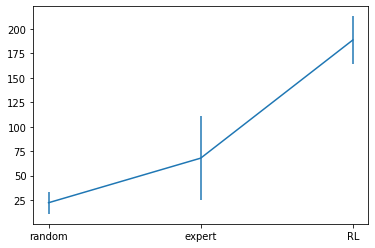

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.xticks(np.arange(len(results_mean_list)), ('random', 'expert', 'RL'))
x = np.arange(len(results_mean_list))
y = np.array(results_mean_list) 
e = np.array(results_std_list)
plt.errorbar(x, y, e)